# ***Detecting presence of Heart Disease using classification***
#### Group Members: Ishan Kumar Singh, Tony Kashimori, Jeffrey Kim

## Introduction

Heart diseases, a global health concern, predominantly affect the elderly. With countless victims each year, early detection remains crucial. 

Our project investigates the likelihood of heart disease using key indicators: age, sex, resting blood pressure, cholesterol, and maximum heart rate.

The primary question is: **"Can age, sex, resting blood pressure, cholesterol, and maximum heart rate predict heart disease?"** 

The data set combines five heart datasets, offering the most extensive collection on heart disease prediction with **918 unique observations** with **12 columns**, focusing on key indicators to assess heart disease risk. Shedding light on these factors' roles, enhances our understanding of future preventive medical approaches.

<img src="https://img.freepik.com/premium-vector/prevention-treatment-heart-disease-cartoon-body-organ-mascot-cute-character-with-medical-dropper-cardiovascular-health-protection-recovery-vector-preventive-medicine-concept_176411-4148.jpg?w=2000" alt="Alternative text" width="300" height="300" />

https://img.freepik.com/premium-vector/prevention-treatment-heart-disease-cartoon-body-organ-mascot-cute-character-with-medical-dropper-cardiovascular-health-protection-recovery-vector-preventive-medicine-concept_176411-4148.jpg?w=740

## Methods

Importing all the libraries that will be used in our data analysis and modeling.

In [47]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(dplyr)

Install the `kknn` package into our server. This will be used in building the model based on knn classification.

In [48]:
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Read in the `heart.csv` data using `read_csv()` and assign it to an object called `data`. The data is accessed using the url `https://raw.githubusercontent.com/jeffreyykim/DSCI-project-009-40-Group_Contract/94fda1d002bf5ab24d2be98a7c63061a1dad7ab0/heart.csv`.

In [49]:
data <- read_csv("https://raw.githubusercontent.com/jeffreyykim/DSCI-project-009-40-Group_Contract/94fda1d002bf5ab24d2be98a7c63061a1dad7ab0/heart.csv")

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We wish to determine the number of `NA` values in our data set. To do this we use the `is.na()`function.

In [50]:
na_number <- sum(is.na(data))
na_number

[1] 0

Since the data set doesn't contain any `NA` values we don't have to drop any observation.

We now begin by wrangling our data. Firstly, we convert our classifier column as a factor and change the responses to `Positive` *(1 in data set)* and `Negative` *(0 in data set)* in accordance with the key as mentioned at the source. We do this to make our predictions more informative and easier to comprehend.

In [51]:
# cleaning and wrangling the data, renaming the values in a column
set.seed(1)
data <- data |>
        mutate(HeartDisease = as_factor(HeartDisease)) |>
        mutate(HeartDisease = fct_recode(HeartDisease, "Positive" = "1", "Negative" = "0"))

We now move on to selecting only the valid columns based on our intuition and the data analysis performed below which showed that  these predictors tend to be influenced by the patients with heart disease. Below each figure we have a description as to how this predictor is influenced by heart diseases.

*(figures 1, 2, 3, 4, and 5 along with Table 1)*

We also remove the values from the selected columns that don't make sense in our analysis. For example, it is impossible for a living person to have their maximum heart rate, resting blood pressure and cholesterol levels to be 0.

Another change included that the categorical variable Sex is converted into quantitative variable by depicting the values as 1, and 0. This allows us to us this a predictor in our analysis by a `knn` model. We change the column name into `Male` which had value 1 for *Male* and 0 for *Female*. Since Sex of the patient may also play a huge role in determining whether they do or do not have a heart disease as implied by the ***figure 1*** below, therefore we wanted to include it into our analysis. 

In [52]:
# selecting only the relevant columns
selected_data <- select(data, HeartDisease, Cholesterol,  Age, RestingBP, MaxHR, Sex) |>
                 filter(Cholesterol != 0, MaxHR !=0, RestingBP != 0) |>
                mutate(Male=as.integer(Sex == "M")) |>
                select(-Sex)
                 # mutate(Sex = as.factor(Sex)) |> mutate(Sex = fct_recode(Sex, "1" = "M", "0" = "F"))
head(selected_data, n = 3)

HeartDisease,Cholesterol,Age,RestingBP,MaxHR,Male
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Negative,289,40,140,172,1
Positive,180,49,160,156,0
Negative,283,37,130,98,1


In our data set `data` 
1) every column is a variable
2) every row is an observation and, 
3) every cell is its own value 
**Therefore, `data` is tidy.**

**Variables used:**
- `HeartDisease` (Positive / Negative) : Patient with or without Heart Disease.
- `Cholesterol` (mm/dl): Cholesterol levels measured in the given unit.
- `Age` (years) : Age of Patient.
- `RestingBP` (mm Hg) : Resting Blood Pressure measured in the given unit.
- `MaxHR` (BPM) : Maximum Heart Rate measured in the given unit.
- `Male` (1: Male / 0: Female) : Sex of Patient


**Procedure**
1) Importing the libraries and data from `Kaggle` into R.
2) Cleaning, wrangling and renaming of data into R. Selecting only columns based on preliminary analysis of data.
3) Splitting into `training` and `testing` data. Scaling the data while making recipes.
4) Find best value of k to be used by `cross validation` of training data.
5) Using this k value to build our model and testing it onto the testing set.
6) Measuring the accuracy and analyzing the confusion matrix.

We split the `selected_data` into training and testing data set according to the proportions `0.75` and `0.25` using `initial_split`. We make sure that the proportion of positive and negative tested patients remain the same in both the data frames using `strata`. 

In [53]:
# spliting data into testing and training sets
data_split <- initial_split(selected_data, prop = 0.75, strata = HeartDisease)
training_data <- training(data_split)
testing_data <- testing(data_split)
head(training_data, n = 3)
head(testing_data, n = 3)

HeartDisease,Cholesterol,Age,RestingBP,MaxHR,Male
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Negative,289,40,140,172,1
Negative,283,37,130,98,1
Negative,204,39,120,145,1


HeartDisease,Cholesterol,Age,RestingBP,MaxHR,Male
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Negative,195,54,150,122,1
Negative,339,39,120,170,1
Negative,237,45,130,170,0


### Preliminary exploratory data analysis

#### Building a bar plot to highlight the proportion of Sex of patients with `HeartDisease`.

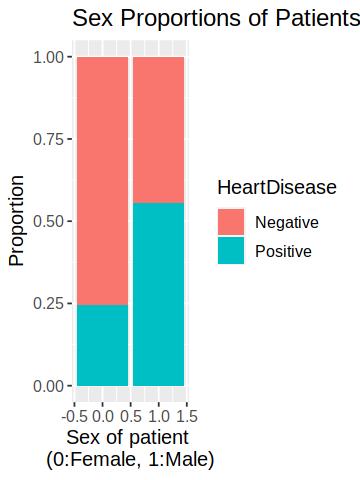

In [54]:
options(repr.plot.width = 3, repr.plot.height = 4)
sex_prop <- ggplot(training_data, aes(x = Male, fill = HeartDisease)) + geom_bar(position = "fill") +
         labs(x = "Sex of patient \n(0:Female, 1:Male)", y = "Proportion", colour = "Heart Disease") + ggtitle("Sex Proportions of Patients") +
         theme(text = element_text(size=12))
sex_prop

***figure 1***

From the figure we observe that the proportion of females that have heart disease is only 0.25 as compared to more than 0.5 in males. Thus, more males tend to be positive for heart diseases.

#### Building a histogram to highlight the distribution of `Cholesterol` levels with `HeartDisease`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


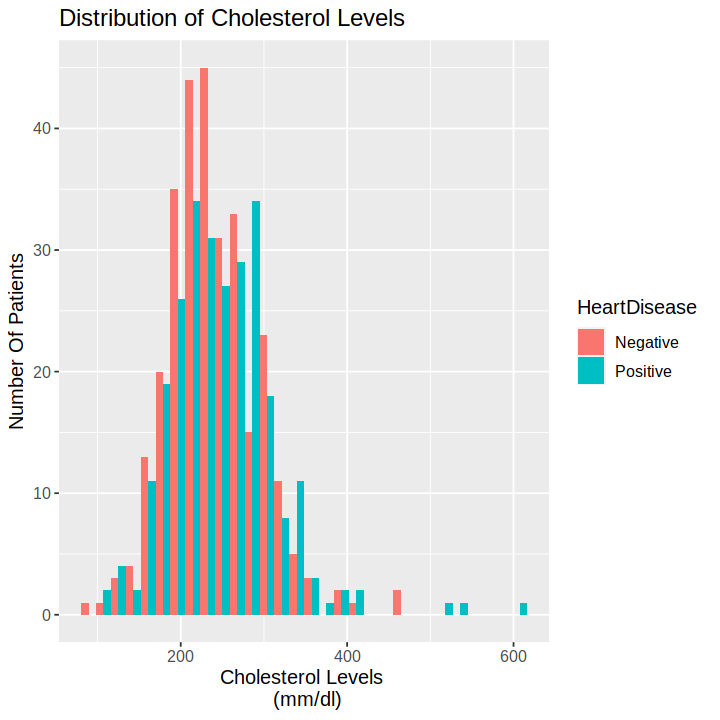

In [55]:
options(repr.plot.width = 6, repr.plot.height = 6)
cholesterol_dist <- ggplot(training_data, aes(x = Cholesterol, fill = HeartDisease)) + geom_histogram(position = "dodge") + 
         labs(x = "Cholesterol Levels \n (mm/dl)", y = "Number Of Patients", colour = "Heart Disease") + ggtitle("Distribution of Cholesterol Levels") +
         theme(text = element_text(size=12)) 
cholesterol_dist

***figure 2***

This distribution does not provide a very clear insight or trend regarding cholesterol levels and heart disease. We can see just a weak trend that people who do not have a heart disease tend to have lower cholesterol levels.

However historically and according to literature *(Cholesterol levels - statpearls - NCBI bookshelf)*, people with higher cholesterol levels tend to have heart diseases and to investigate the certainty of that statement we included this graph in our analysis.

#### Plotting the distribution of `RestingBP` in patients with `HeartDisease`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


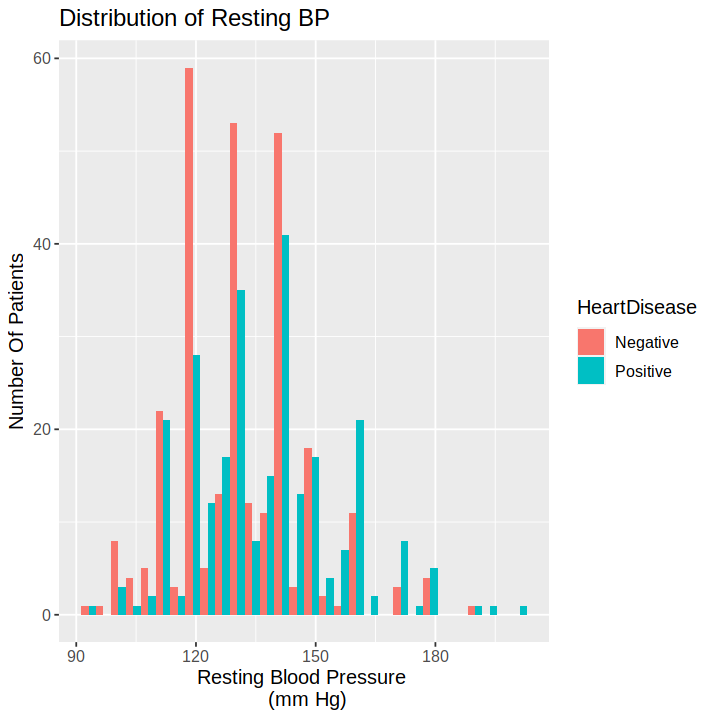

In [56]:
restbp_dist <- ggplot(training_data, aes(x = RestingBP, fill = HeartDisease)) + geom_histogram(position = "dodge") + 
         labs(x = "Resting Blood Pressure \n (mm Hg)", y = "Number Of Patients", colour = "Heart Disease") + ggtitle("Distribution of Resting BP") +
         theme(text = element_text(size=12)) 
restbp_dist

***figure 3***

The plot above shows that there are more number of people without heat diseases at lower resting blood pressures then number of people with heart diseases and the number for the latter increases as we increase resting blood pressure. Thus, elevated resting blood pressure could be an indication for heart disease.

#### Building the distribution of `HeartDisease` Patients and their `Age`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


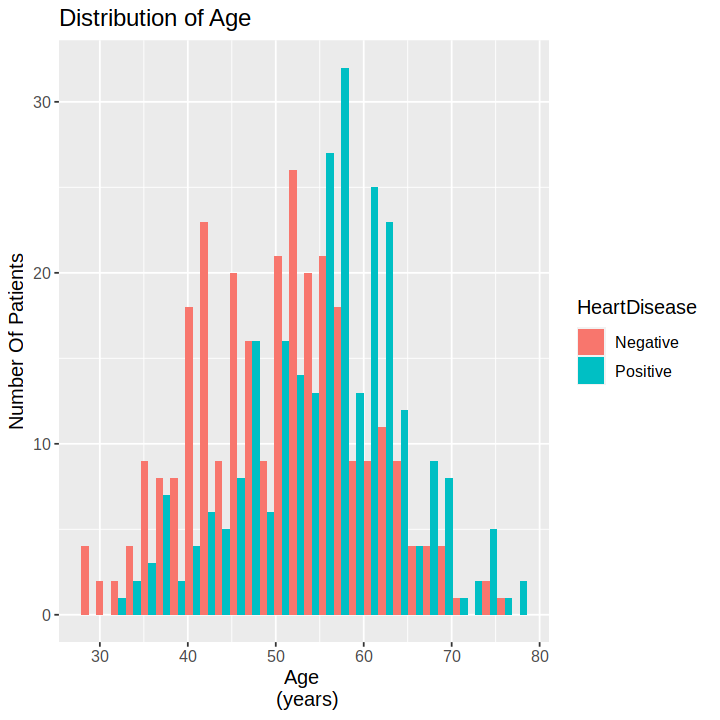

In [57]:
age_dist <- ggplot(training_data, aes(x = Age, fill = HeartDisease)) + geom_histogram(position = "dodge") + 
         labs(x = "Age \n (years)", y = "Number Of Patients", colour = "Heart Disease") + ggtitle("Distribution of Age") +
         theme(text = element_text(size=12)) 
age_dist

***figure 4***

From the plot, we can conclude that heart diseases tend to target older people. The number of people above the age of 55 years is consistently higher than the number of people without heart diseases.

#### Showing the distribution of `MaxHR` of `HeartDisease` patients

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


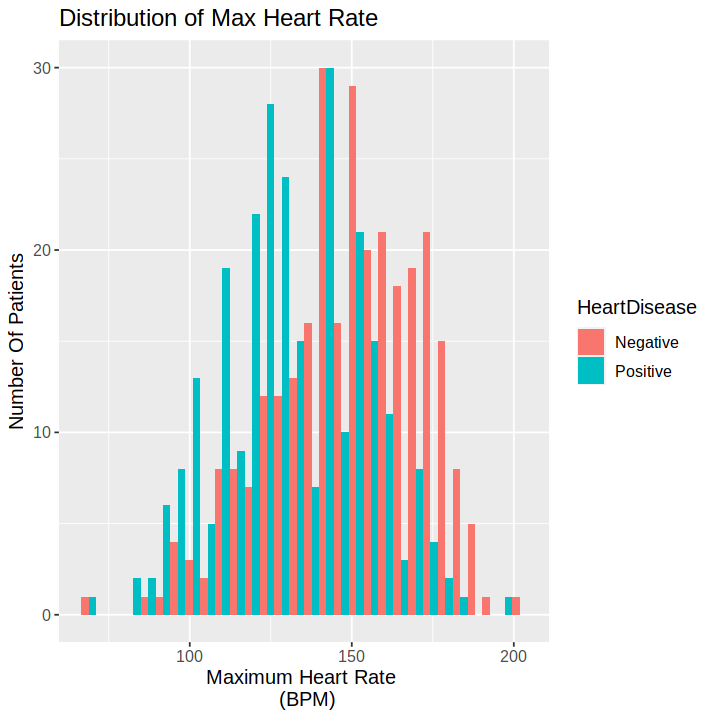

In [58]:
maxhr_dist <- ggplot(training_data, aes(x = MaxHR, fill = HeartDisease)) + geom_histogram(position = "dodge") + 
         labs(x = "Maximum Heart Rate \n (BPM)", y = "Number Of Patients", colour = "Heart Disease") + ggtitle("Distribution of Max Heart Rate") +
         theme(text = element_text(size=12)) 
maxhr_dist

***figure 5***

There is a clear yet surprising trend that we observe. The maximum heart rate for patients with heart disease is significantly lower than that for patients without heart diseases.

In [59]:
# characteristics of the training data
training_data |>
group_by(HeartDisease, Male) |>
summarize(Mean_Cholesterol = mean(Cholesterol, na.rm = TRUE), Mean_Age = mean(Age, na.rm = TRUE), Mean_RestingBP = mean(RestingBP, na.rn = TRUE),
          Mean_MaxHR = mean(MaxHR, na.rm = TRUE))

`summarise()` has grouped output by 'HeartDisease'. You can override using the
`.groups` argument.


HeartDisease,Male,Mean_Cholesterol,Mean_Age,Mean_RestingBP,Mean_MaxHR
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Negative,0,252.3048,51.26667,130.0095,148.3810
Negative,1,233.0695,49.68984,131.0053,149.5561
Positive,0,275.1765,55.82353,143.0294,141.5882
Positive,1,245.6438,55.88412,135.9485,129.9957


***Table 1***

Through the table we can see that for both genders 0 (female) and 1 (male) patients with heart disease generally have higher cholesterol levels, age, and resting blood pressure with low max heart rate as compared to patients without heart diseases.

### Building The Model

We start by building the recipe for our model using `recipe()`. Centering and scaling of all the predictors is done through the functions `step_center` and `step_scale` functions.

While building the model for our data we use `nearest_neighbor()`, specify the engine as `kknn` and the mode to `classification`.

In [60]:
set.seed(1)
knn_recipe <- recipe(HeartDisease ~ . , data = training_data) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors()) 
knn_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
knn_spec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Centering for all_predictors()
Scaling for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We'll be performing cross-validation using a 5 fold validation set. We do this using `vfold_cv()` function and defining the `strata` as HeartDisease so that all the validation sets are stratified

Next up we fit the model to the training set and recipe using `workflow()` with the 5 validation sets.

In [61]:
set.seed(1)

grid_vals <- tibble(neighbors = 1:50)

knn_vfold <- vfold_cv(training_data, v = 5, strata = HeartDisease)


knn_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = knn_vfold, grid = grid_vals)

After fitting the model we wish to determine the value of K with the most accuracy. We use the `collect_metrics()` function to get the accuracy and then we'll be plotting the values of accuracy vs k to find the k with highest accuracy.

In [62]:
knn_res <- knn_fit |> 
            collect_metrics() |>
            filter(.metric == "accuracy")
knn_res

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6440883,5,0.01340722,Preprocessor1_Model01
2,accuracy,binary,0.6440883,5,0.01340722,Preprocessor1_Model02
3,accuracy,binary,0.6655824,5,0.01061307,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.7081241,5,0.01774798,Preprocessor1_Model48
49,accuracy,binary,0.7117277,5,0.01666215,Preprocessor1_Model49
50,accuracy,binary,0.7117277,5,0.01666215,Preprocessor1_Model50


We plot the collected accuracy and `pull()` the value of nearest neighbor with highest accuracy. We will use this value of k to determine build the final model and use that model on our test data.

[1] 27

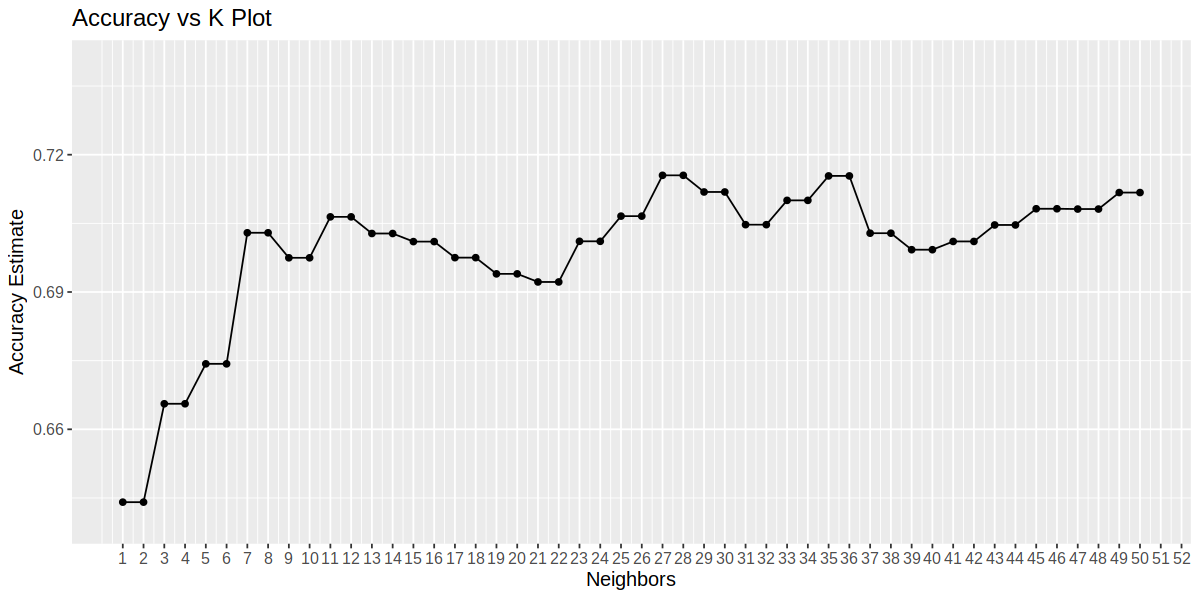

In [63]:
options(repr.plot.width = 10, repr.plot.height = 5)
accuracy_versus_k <- ggplot(knn_res, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      theme(text = element_text(size = 12)) +
      scale_x_continuous(breaks = seq(1, 200, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.64, 0.74)) + # adjusting the y-axis 
      ggtitle("Accuracy vs K Plot")
accuracy_versus_k
max_k <- knn_res |> filter(mean==(max(mean))) |> slice_min(neighbors) |> pull(neighbors)
max_k

***figure 6***

The first point where we get the maximum accuracy is at k = 27.

We build our model in the same way we did earlier except this time around we make use of `max_k` taken from the plot above. 

We fit the newer/improved model in a `workflow()` and then predict the values for `testing_data` using `predict()` function.
We use `bind_cols()` to bind the predicted values to `testing_data` and name it `test_predictions`.

In [64]:
max_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = max_k) |>
            set_engine("kknn") |>
            set_mode("classification")
max_k_spec
max_k_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(max_k_spec) |>
            fit(data = training_data)

test_predictions <- predict(max_k_fit , testing_data) |>
      bind_cols(testing_data)
head(test_predictions, n = 3)

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = max_k
  weight_func = rectangular

Computational engine: kknn 


.pred_class,HeartDisease,Cholesterol,Age,RestingBP,MaxHR,Male
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Positive,Negative,195,54,150,122,1
Negative,Negative,339,39,120,170,1
Negative,Negative,237,45,130,170,0


We wish to determine the accuracy of our test predictions. We use `metrics()` function to perform this task. The `truth`value is set to `HeartDisease` and `estimate` to `.pred_class`

In [65]:
test_prediction_accuracy <- test_predictions |>
        metrics(truth = HeartDisease, estimate = .pred_class)    
test_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7593583
kap,binary,0.5178479


We get a remarkable accuracy of `75.9%` from our model. This is even better than the accuracy we received while training the data. 

We move on to dig deeper into the kinds of errors our model makes by figuring out **precision** and **recall** using a **confusion matrix**. 

The confusion matrix below is described as:
1) First  Column First   Row -> True  Negative -> People correctly predicted who don't have heart diseases.
2) First  Column Second  Row -> False Negative -> People incorrectly predicted to not have heart diseases when they actually did.
3) Second Column First   Row -> False Positive -> People incorrectly predicted to have heart diseases when they actually did not.
4) Second Column Second  Row -> True  Positive -> People correctly predicted who did have heart diseases.

In [66]:
confusion_mat <- test_predictions |> 
      conf_mat(truth = HeartDisease, estimate = .pred_class)
confusion_mat

          Truth
Prediction Negative Positive
  Negative       75       22
  Positive       23       67

Precision quantifies how many of the positive predictions the classifier made were actually positive and recall talks about how many of the positive observations in the test set were identified as positive.

In [67]:
precision <- 67 / (67 + 23)
print(paste("The precision is", precision))
recall <- 67 / (67 + 22)
print(paste("The recall is", recall))

[1] "The precision is 0.744444444444444"
[1] "The recall is 0.752808988764045"


When we run the model on test set, we get a precision of `74.44%` and recall of about `75.28%`. This means that `74.44%` of the times our model predicts what is actually a positive value for Heart Disease (precision) and that `75.28%` of the positive values were identified correctly (recall). Even though there is still scope for improvement, this is a remarkable starting point for the model.

To further investigate the tuning of our classifier we make use of baseline predictions using majority classifier. Even though the number of positive and negative cases are roughly equal we do perform this step. Approximate accuracy of the majority classifier is usually close to the majority proportion in the training data.

In [68]:
# baseline majority predictions
majority_preds <- training_data |> group_by(HeartDisease) |> summarize(n = n()) |> mutate(percent = n/nrow(training_data))
majority_preds

HeartDisease,n,percent
<fct>,<int>,<dbl>
Negative,292,0.5223614
Positive,267,0.4776386


Our model does a far better job than baseline predictions, since the accuracy of `75.9%` is far greater than `52.2%` for majority predictions.

## Discussion

### Summary of Findings:


#### Correlation with Heart Disease Risk Factors:
- Age: The data suggested a strong correlation between age and heart disease, aligning with common medical understanding. Older individuals showed a higher prevalence of heart disease.
- Resting Blood Pressure: Individuals with higher resting blood pressure were more likely to have heart disease. This finding is consistent with medical research indicating hypertension as a risk factor for cardiovascular conditions.
- Cholesterol Levels: Higher cholesterol levels were associated with an increased risk of heart disease. This aligns with established knowledge about the role of cholesterol in heart health.
- Maximum Heart Rate: An inverse relationship was observed here; lower maximum heart rates were more common in individuals with heart disease. This could reflect the decreased cardiovascular efficiency often seen in heart disease patients.
#### Gender Differences in Heart Disease Prevalence:
- The analysis revealed a higher incidence of heart disease in males compared to females. This finding prompts further investigation into the biological, lifestyle, and genetic factors that might contribute to this disparity.
####  Predictive Modeling:
The project utilized knn classification techniques to predict heart disease presence based on the identified key indicators. The effectiveness of these predictions is crucial, as it directly impacts the model's utility in clinical settings. We get out accuracy to be about `75.9%` with a precision of `74.44%` and recall of `75.2%`. We wish to increase our accuracy further along with the recall. Recall in our problem's context carries more weight than precision as it is crucial to identify all the individuals with heart diseases so that they can get treatment immediately. Misclassifying these patients could be potentially life threatening and should be consulted to a trained professional immediately. On the contrary, if a person without heart disease is classified as "Positive" then getting a second opinion wouldn't hurt and that patient could be showing some risk factors due to which the model predicted the patient to have heart disease. In such cases, consulting a doctor could be extremely beneficial.

However, dwelling deeper into some specific risk factors from our analysis that showed more correlation (like age, sex and maximum heart rate) could help improve accuracy and provide more valuable insights into the world of heart disease  

#### Expectations vs. Reality:
These findings align with the initial expectations of the project as proposed. The correlation between the identified factors (resting blood pressure, cholesterol levels, age, maximum heart rates) and heart disease was anticipated based on existing medical knowledge.
The gender disparity in heart disease prevalence, with males being more affected than females, is something we can delve further in.
#### Impact of the Findings:


- Medical Industry: The model, with further refinement, could significantly aid in early diagnosis and prevention of heart diseases, potentially saving lives and reducing healthcare costs.
- Research and Medical Practice: These findings could influence future research directions and help clinicians in risk assessment and developing personalized treatment plans.
- Public Health: Understanding these correlations can inform public health policies and educational campaigns focused on heart disease prevention.


#### Future Research Questions:


1) Gender Disparity: Why are males more susceptible to heart disease than females? This could lead to investigations into biological, genetic, lifestyle, and socio-cultural factors influencing heart disease prevalence among different genders.
2) Most Influential Factor: Among age, sex, resting blood pressure, cholesterol, and maximum heart rate, which has the most significant impact on heart disease risk? This could lead to more focused studies on individual risk factors.
3) Improving Predictive Models: How can the accuracy of predictive models be enhanced? This includes exploring additional variables, refining data analysis techniques, and integrating machine learning advancements


## Reference List
- fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
- Cholesterol levels - statpearls - NCBI bookshelf. (n.d.). https://www.ncbi.nlm.nih.gov/books/NBK542294/ 
- Tiffany Timbers, T. C. (2023, August 31). Data science. Chapter 1 R and the Tidyverse. http://datasciencebook.ca/intro.html 

**For the data set:**
Every dataset used can be found under the Index of heart disease datasets from UCI Machine Learning Repository on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

Creators:

    Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
    University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
    University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
    V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Donor:
David W. Aha (aha '@' ics.uci.edu) (714) 856-8779